# Lane Detection

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [55]:
def show(img):
    # Display the image
    # We habe to convert the color to display correctly
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axis
    plt.show()

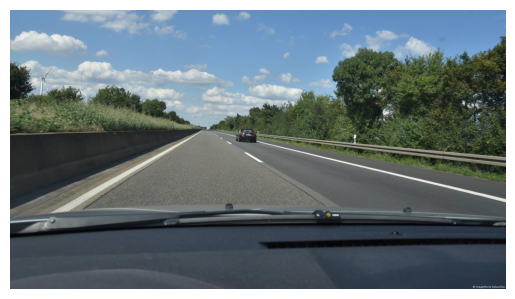

In [56]:
img = cv2.imread("../Real_Test.jpg")
show(img)

In [57]:
def detectLanes_v1(img):

    output_img = img.copy()

    # image processing
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.Canny(img, 50, 150)

    # get the lines
    lines = cv2.HoughLinesP(img, rho = 1, theta = np.pi/180, threshold = 20, minLineLength = 20, maxLineGap = 500)
    
    # average the lines to one left, one right 
    left_lines    = [] 
    left_weights  = [] 
    right_lines   = [] 
    right_weights = [] 

    for line in lines:

        x1, y1, x2, y2 = line[0] 
        if x1 == x2:
            continue

        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - (slope * x1)
        length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))

        if slope < 0:
            left_lines.append((slope, intercept))
            left_weights.append((length))
        else:
            right_lines.append((slope, intercept))
            right_weights.append((length))

    ll  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    rl = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None

    # get coordinats in pixels from the slope / intercept
    if ll is None or rl is None:
        pass

    y1 = img.shape[0]
    y2 = 0
    x1 = int((y1 - ll[1]) / ll[0])
    x2 = int((y2 - ll[1]) / ll[0])
    left_lane = [x1, y1, x2, y2]

    x1 = int((y1 - rl[1]) / rl[0])
    x2 = int((y2 - rl[1]) / rl[0])
    right_lane = [x1, y1, x2, y2]

    # calculate the center of both lines
    xm1 = int((left_lane[0] + right_lane[0]) / 2)
    xm2 = int((left_lane[2] + right_lane[2]) / 2)
    middle_lane = [xm1, y1, xm2, y2]

    cv2.line(output_img, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), (0, 0, 255), 3)
    cv2.line(output_img, (right_lane[0], right_lane[1]), (right_lane[2], right_lane[3]), (255, 0, 0), 3)
    cv2.line(output_img, (middle_lane[0], middle_lane[1]), (middle_lane[2], middle_lane[3]), (0, 255, 0), 3)

    return output_img

# 2. Improved View (ROI)

To overcome this problem, we can mask the image to only select a region of intrest (ROI).
We use a mask to do that. The mask should in any shape, so we use polygons to slect a region.
To make this easier, we build small an point selection tool.

In [58]:
import cv2
import numpy as np

clicked_points = []

def onClick(event, x, y, flags, param):
    global img
    
    # save mouse position in list of points
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_points.append([x, y])
        copy = img.copy()
        cv2.putText(copy, f"(Added Point: {x}, {y})", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        cv2.imshow('Selection', copy)
    
    # show current mouse positon
    if event == cv2.EVENT_MOUSEMOVE:
        copy = img.copy()
        cv2.putText(copy, f"({x}, {y})", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        cv2.imshow('Selection', copy)

def run():
    img = cv2.imread('Real_Test.jpg')

    cv2.namedWindow('Selection')
    cv2.setMouseCallback('Selection', onClick)

    cv2.imshow('Selection', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    print("You god:", clicked_points)

# run()

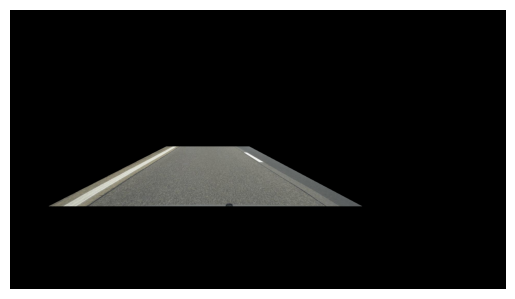

(1080, 1920, 3)


In [59]:
mask = np.zeros_like(img)
# define the the polygon
vertices = np.array([[150, 759], [1362, 759], [926, 528], [604, 528]])
# dill the polygon with white color
cv2.fillPoly(mask, [vertices], (255, 255, 255))
# apply the mask to the image using bitwise AND operation
masked_image = cv2.bitwise_and(img, mask)

show(masked_image)
print(masked_image.shape)

But we can do better. Instead of "cuting" the ROI of the image and make the other part black, we can use: Inverse Perspective Mapping / Transformation.

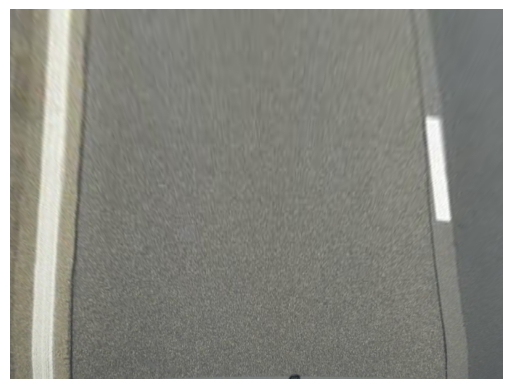

In [60]:
# tl, bl, tr, br
# the arrays must be numpy arrays
orig = np.array([[604, 528], [150, 759], [926, 528], [1362, 759]], dtype=np.float32)
trans = np.array([[0, 0], [0, 600], [800, 0], [800, 600]], dtype=np.float32)

# output an matrix that multiplied with the input image outputs the transformt image
transformer_matrix = cv2.getPerspectiveTransform(orig, trans)

transformed_img = cv2.warpPerspective(img, transformer_matrix, (800, 600))

show(transformed_img)


We can increase to white in the image, to make the edges between road an lane sharper.
Therefore we create a mask with the white spots first.

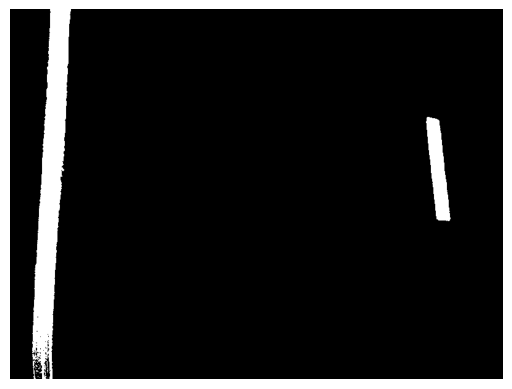

In [61]:
# Convert the image to grayscale
gray_image = cv2.cvtColor(transformed_img, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image to isolate white regions
_, white_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

show(white_mask)



Now we can blend the mask with the image.

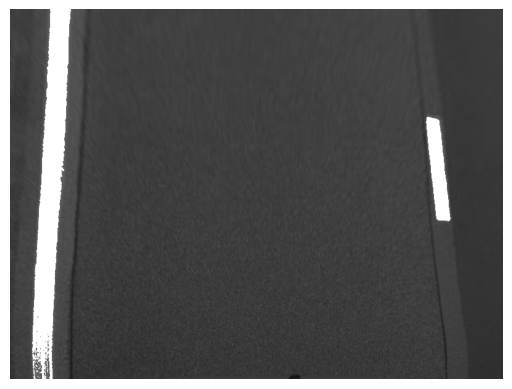

In [62]:
# Brighten the original image where white regions are present
# cv2.addWeighted(src1, alpha, src2, beta,y) is a methode to blend two images
# the first value and the second determin how much each impact each image have
# the third is a constant
brightened_image = cv2.addWeighted(gray_image, 0.5, white_mask, 1, 0)

show(brightened_image)

Now we can apply our lane detection on it.

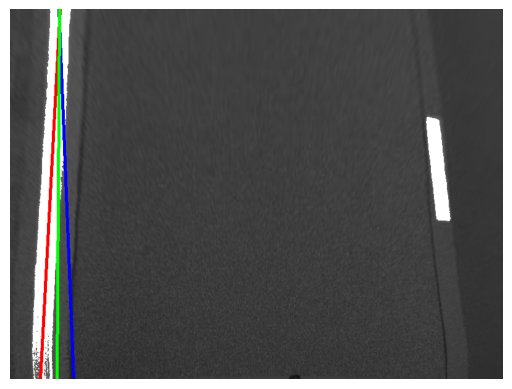

In [63]:
processed_img = detectLanes_v1(cv2.cvtColor(brightened_image, cv2.COLOR_GRAY2BGR))
show(processed_img)

But before we can apply the new filter and image processes to our lane detection, we have to fit the detected lanes back in the originial image. 
We do that by reversing the Prespective Transformation and blend the altered image back into the original.

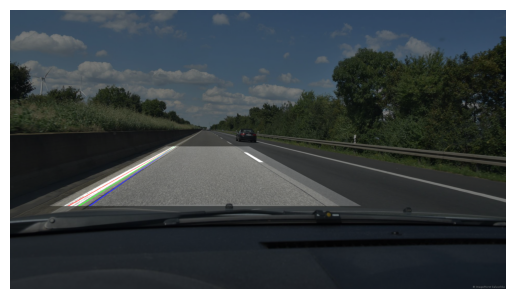

In [64]:
# tl, bl, tr, br
# the arrays must be numpy arrays
orig = np.array([[604, 528], [150, 759], [926, 528], [1362, 759]], dtype=np.float32)
trans = np.array([[0, 0], [0, 600], [800, 0], [800, 600]], dtype=np.float32)

# output an matrix that multiplied with the input image outputs the transformt image
transformer_matrix = cv2.getPerspectiveTransform(trans, orig)

# the original image has the size 1920, 1080
transformed_img = cv2.warpPerspective(processed_img, transformer_matrix, (1920, 1080))

result = cv2.addWeighted(img, 0.5, transformed_img, 1, 0)

show(result)

Now we can implement this in detectLanes_v1 to make detectLanes_v2.

In [65]:
def detectLanes_v2(img):

    working_copie = img.copy()

    orig = np.array([[604, 528], [150, 759], [926, 528], [1362, 759]], dtype=np.float32)
    trans = np.array([[0, 0], [0, 600], [800, 0], [800, 600]], dtype=np.float32)

    transformer_matrix = cv2.getPerspectiveTransform(orig, trans)
    # maybe other size than 800, 600 ????
    working_copie = cv2.warpPerspective(working_copie, transformer_matrix, (800, 600))

    edges = working_copie.copy()

    # image processing
    edges = cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
    
    _, white_mask = cv2.threshold(edges, 200, 255, cv2.THRESH_BINARY)
    edges = cv2.addWeighted(edges, 0.5, white_mask, 1, 0)
    
    edges = cv2.GaussianBlur(edges, (5, 5), 0)
    edges = cv2.Canny(edges, 50, 150)

    # get the lines
    lines = cv2.HoughLinesP(edges, rho = 1, theta = np.pi/180, threshold = 20, minLineLength = 20, maxLineGap = 500)
    
    # average the lines to one left, one right 
    left_lines    = [] 
    left_weights  = [] 
    right_lines   = [] 
    right_weights = [] 

    for line in lines:

        x1, y1, x2, y2 = line[0] 
        if x1 == x2:
            continue

        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - (slope * x1)
        length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))

        if slope < 0:
            left_lines.append((slope, intercept))
            left_weights.append((length))
        else:
            right_lines.append((slope, intercept))
            right_weights.append((length))

    ll  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    rl = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None

    # get coordinats in pixels from the slope / intercept
    if ll is None or rl is None:
        pass

    y1 = img.shape[0]
    y2 = 0
    x1 = int((y1 - ll[1]) / ll[0])
    x2 = int((y2 - ll[1]) / ll[0])
    left_lane = [x1, y1, x2, y2]

    x1 = int((y1 - rl[1]) / rl[0])
    x2 = int((y2 - rl[1]) / rl[0])
    right_lane = [x1, y1, x2, y2]

    # calculate the center of both lines
    xm1 = int((left_lane[0] + right_lane[0]) / 2)
    xm2 = int((left_lane[2] + right_lane[2]) / 2)
    middle_lane = [xm1, y1, xm2, y2]

    cv2.line(working_copie, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), (0, 0, 255), 5)
    cv2.line(working_copie, (right_lane[0], right_lane[1]), (right_lane[2], right_lane[3]), (255, 0, 0), 5)
    cv2.line(working_copie, (middle_lane[0], middle_lane[1]), (middle_lane[2], middle_lane[3]), (0, 255, 0), 5)

    transformer_matrix = cv2.getPerspectiveTransform(trans, orig)

    # the original image has the size 1920, 1080
    working_copie = cv2.warpPerspective(working_copie, transformer_matrix, (1920, 1080))

    img = cv2.addWeighted(img, 0.5, working_copie, 1, 0)

    return img

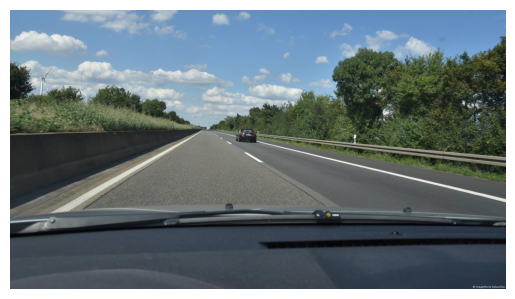

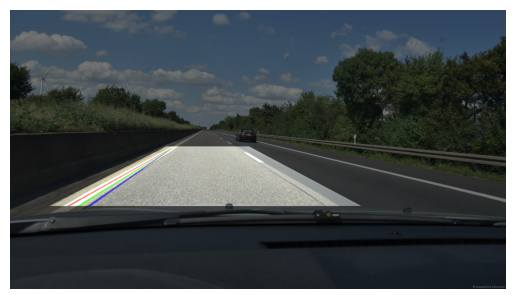

In [66]:
img = cv2.imread("../Real_Test.jpg")
show(img)
show(detectLanes_v2(img))

Thats working well. But there is a big problem or better two say, there are two problems.
1. Because there is only a clear line on the left, we cannot get the center of to lanes as ourer driving guide.
2. Because the Hough Line Detection detected more than one line on the left and some lines have a the "right side slope", it fits both lines on the left.